In [4]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
from tensorflow.keras.callbacks import EarlyStopping as EarlyStopping
from tensorflow.python.client import device_lib
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import numpy as np
import os
import re
import time
import string
import glob

TensorFlow 2.x selected.
Tensorflow version: 2.0.0


Using TensorFlow backend.


In [5]:
# Devices informations
print("Devices:\n", device_lib.list_local_devices())
print("GPU:", tf.test.gpu_device_name())

Devices:
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12472054844300253970
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4828310425430406359
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4257862428345343190
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330053735
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12212173027285556294
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
GPU: /device:GPU:0


In [0]:
!git clone https://github.com/michalovsky/books_data.git

In [83]:
# Read all file paths from directory
directory = "books_data/kafka/"
file_paths = glob.glob(directory +"*.txt")    
print("Found", len(file_paths), "text files in directory:", directory)

Found 1 text files in directory: books_data/kafka/


In [84]:
# Extract text from all text files
text = ""

for file_path in file_paths:
    with open(file_path, 'r') as file:
        file_content = file.read()
        #remove file beginning and ending from gutenberg books
        file_content = file_content[file_content.find("*** START"):file_content.rfind("*** END")]
        #remove file ending from wolnelektury books
        file_content = file_content[:file_content.rfind("-----")]
        text+=file_content
print ('Length of text: {} characters'.format(len(text)))

Length of text: 119433 characters


In [85]:
# Preprocess data

punctuation_translator = str.maketrans('–—”„…«»‘’“', '          ', string.punctuation)
digits_translator = str.maketrans('', '', string.digits)
special_characters_translator = str.maketrans('ąćęłńóśźżäöüæèêéô', 'acelnoszzaoueeeeo', '')

# remove redundant characters and translate special characters
text = text.lower().translate(punctuation_translator).translate(digits_translator).translate(special_characters_translator)

# remove "tom <number>" strings 
text = re.sub(r"\ntom\s(.*)\n", "", text)

# remove "rozdzial <number>" strings 
text = re.sub(r"\nrozdzial\s(.*)\n", "", text)

# remove "chapter <number>" strings 
text = re.sub(r"\nchapter\s(.*)\n", "", text)

# remove "letter <number>" strings 
text = re.sub(r"\nletter\s(.*)\n", "", text)

#remove extra spaces and new lines
text = ' '.join(text.split())

print ('Length of text after preprocessing: {} characters'.format(len(text)))

Length of text after preprocessing: 115574 characters


In [86]:
# split text into words
words = text.split(" ")
print ('Amount of words: {}'.format(len(words)))

Amount of words: 22043


In [0]:
# Creating a mapping from unique characters to indices

vocab = sorted(set(text))
vocab_length = len(vocab)

char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

#encode text from characters to numbers  
encoded = np.array([char2idx[ch] for ch in text])  

In [88]:
# Print unique characters
print ('{} unique characters:'.format(len(vocab)))

print('{')
for char in char2idx:
    print('  {:4s}:{:3d},'.format(repr(char), char2idx[char]))
print('}')

27 unique characters:
{
  ' ' :  0,
  'a' :  1,
  'b' :  2,
  'c' :  3,
  'd' :  4,
  'e' :  5,
  'f' :  6,
  'g' :  7,
  'h' :  8,
  'i' :  9,
  'j' : 10,
  'k' : 11,
  'l' : 12,
  'm' : 13,
  'n' : 14,
  'o' : 15,
  'p' : 16,
  'q' : 17,
  'r' : 18,
  's' : 19,
  't' : 20,
  'u' : 21,
  'v' : 22,
  'w' : 23,
  'x' : 24,
  'y' : 25,
  'z' : 26,
}


In [89]:
# The maximum length sentence we want for a single input in characters
sequence_length = 30

# Create trainging examples
x_data = []
y_data = []

for i in range(0, len(text) - sequence_length, 1):
    x_sequence = text[i:i + sequence_length]
    y_label = text[i + sequence_length]

    # We now convert list of characters to integers based on
    # previously and add the values to our lists
    x_data.append([char2idx[char] for char in x_sequence])
    y_data.append(char2idx[y_label])

data_length = len(x_data)
print("Amount of data", data_length)
X = np.reshape(x_data, (data_length, sequence_length, 1))
X = X/float(vocab_length)

# one hot encoding
y = np_utils.to_categorical(y_data)

# char_dataset = tf.data.Dataset.from_tensor_slices(encoded)

# # Create sequences from dataset
# sequences = char_dataset.batch(sequence_length+1, drop_remainder=True)

Amount of data 115544


In [0]:
#first 10 sequence batches
# for item in sequences.take(10):
#   print(repr(''.join(idx2char[item.numpy()])))

In [0]:
# Transform each sequence into two sequences: input(same as sequence), target (shifted by one index)

# def split_input_target(chunk):
#   input_text = chunk[:-1]
#   target_text = chunk[1:]
#   return input_text, target_text

# dataset = sequences.map(split_input_target)

In [0]:
# First input data and corresponding target data
# for input_example, target_example in  dataset.take(1):
#   print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
#   print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'start of this project gutenber'
Target data: 'tart of this project gutenberg'


In [0]:
# Shuffle dataset
# batch_size = 64
# steps_per_epoch = examples_per_epoch//batch_size
# buffer_size = 10000
# dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

In [0]:
# Defining function building model with two GRU Rnn layers and output to dense layer 
# def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
#     model = tf.keras.Sequential([
#         tf.keras.layers.Embedding(vocab_size, embedding_dim,
#                                   batch_input_shape=[batch_size, None]),
#         tf.keras.layers.LSTM(rnn_units,
#             return_sequences=True,
#             recurrent_initializer='glorot_uniform',
#             stateful=True),
#         tf.keras.layers.LSTM(rnn_units,
#             return_sequences=True,
#             recurrent_initializer='glorot_uniform',
#             stateful=True),
    
#         tf.keras.layers.Dense(vocab_size)])
#     return model

In [134]:
# # Length of the vocabulary (amount of unique characters)
# vocab_size = len(vocab)

# # The embedding dimension
# embedding_dim = 256

# # Number of RNN units
# rnn_units = 1024

# # Build model
# model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)

model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(1024, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
# model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))

# Model informations
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 30, 256)           264192    
_________________________________________________________________
lstm_10 (LSTM)               (None, 30, 1024)          5246976   
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 1024)          0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 256)               1311744   
_________________________________________________________________
dense_3 (Dense)              (None, 27)                6939      
Total params: 6,829,851
Trainable params: 6,829,851
Non-trainable params: 0
_________________________________________________________________


In [0]:
# # Define loss function

# def loss(labels, logits):
#   return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [0]:
# model.compile(
#     optimizer = tf.optimizers.Adam(),
#     loss = loss
#     )

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    save_best_only=True)

callbacks = [checkpoint_callback, es]

In [0]:
# batch_size = 64
# examples_per_epoch = len(encoded)//sequence_length
# steps_per_epoch = examples_per_epoch//batch_size
history = model.fit(X, y, epochs=20, validation_split=0.1, batch_size=256, verbose=2, callbacks=callbacks)

Train on 103989 samples, validate on 11555 samples
Epoch 1/20


In [98]:
tf.train.latest_checkpoint(checkpoint_dir) #second param direct file: "ckpt_50"

'./training_checkpoints/ckpt_20'

In [0]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [0]:
def generate_text(model):
  random_index = np.random.randint(0, len(X)-1)
  new_string = x_data[random_index]
  print(new_string)
  print ('random seed data: ', repr(''.join(idx2char[new_string])))

  text_generated = []

  model.reset_states()
  for i in range(100):
      x = np.reshape(new_string, (1, len(new_string), 1))
      x = x/float(vocab_length)

      index = np.argmax(model.predict(x))
      result = idx2char[index]

      new_string = np.append(new_string, index)
      new_string = new_string[1:len(new_string)]
      print(new_string)
      text_generated.append(result)

  return ''.join(text_generated)

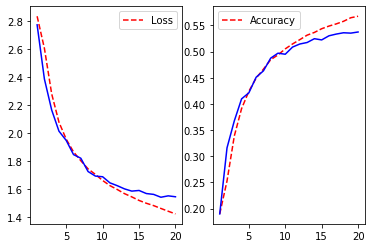

In [120]:
import matplotlib.pyplot as plt
# Get training loss for the model to see if we converged correctly
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 3]})

a0.plot(epoch_count, training_loss, 'r--')
a0.plot(epoch_count, validation_loss, 'b-')
a0.legend(['Loss'])
# a0.xlabel('Epoch')
# a0.ylabel('Loss')

# f.tight_layout()
# f.savefig('grid_figure.pdf')

a1.plot(epoch_count, training_acc, 'r--')
a1.plot(epoch_count, validation_acc, 'b-')
a1.legend(['Accuracy'])
# a1.xlabel('Epoch')
# a1.ylabel('Loss')

# # Visualize loss history
# plt.figure(figsize=(16,9))
# plt.plot(epoch_count, training_loss, 'r--')
# plt.plot(epoch_count, validation_loss, 'b-')
# plt.legend(['Training Loss'])
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()


In [133]:
print(generate_text(model))
# margaret tried up the home that noone else way his head kep

[5, 13, 2, 5, 18, 0, 23, 8, 1, 20, 19, 0, 2, 5, 5, 14, 0, 1, 3, 8, 9, 5, 22, 5, 4, 0, 9, 14, 0, 20]
random seed data:  'ember whats been achieved in t'
[13  2  5 18  0 23  8  1 20 19  0  2  5  5 14  0  1  3  8  9  5 22  5  4
  0  9 14  0 20  8]
[ 2  5 18  0 23  8  1 20 19  0  2  5  5 14  0  1  3  8  9  5 22  5  4  0
  9 14  0 20  8  5]
[ 5 18  0 23  8  1 20 19  0  2  5  5 14  0  1  3  8  9  5 22  5  4  0  9
 14  0 20  8  5  0]
[18  0 23  8  1 20 19  0  2  5  5 14  0  1  3  8  9  5 22  5  4  0  9 14
  0 20  8  5  0  6]
[ 0 23  8  1 20 19  0  2  5  5 14  0  1  3  8  9  5 22  5  4  0  9 14  0
 20  8  5  0  6 12]
[23  8  1 20 19  0  2  5  5 14  0  1  3  8  9  5 22  5  4  0  9 14  0 20
  8  5  0  6 12 15]
[ 8  1 20 19  0  2  5  5 14  0  1  3  8  9  5 22  5  4  0  9 14  0 20  8
  5  0  6 12 15 15]
[ 1 20 19  0  2  5  5 14  0  1  3  8  9  5 22  5  4  0  9 14  0 20  8  5
  0  6 12 15 15 18]
[20 19  0  2  5  5 14  0  1  3  8  9  5 22  5  4  0  9 14  0 20  8  5  0
  6 12 15 15 18  0]
[19  0  2  